## Task 08: Testing. Load pre-trained models and evaluate on test images
-----------------------------------------------------------------------------------------------------
Author: Rajesh Siraskar
Created: 08-Jan-2019
- 08-Jan-2019: Extract out testing code from Task_04 notebook as separate notebook for testing
    - Introduce the idea and concept of **Perspective Map**
- 14-Jan-2019: Add NMS to supress extra bounding boxes
     - Change code to create a lost of bounding boxes and plotting at the end and not in the loop
     - Non-maximum supression helps in reducing overlapping bounding-boxes
     Ref.: (Dalal 2006: 26) Fig. 3.5
     Ref.: https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
     

In [13]:
reset -f

## Set top level parameters

In [14]:
## Imports

# Plot images inline with document
%matplotlib inline

# Import standard modules
import cv2            # OpenCV 
import numpy as np    # N dimensional array handling
import glob           # file handling

from matplotlib import pyplot as plt # for displaying images and plots
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

# Import custom functions
from HoG_V2 import HoG_V2

## Image folders
path_test_images = 'images/TEST_IMAGES/'
annotated_images_path = path_test_images + 'Annotated/'
file_type = '*.png'

### Perspective map and View-port size

This term has been coined by the student-author to describe a mechanism of scanning the test frame with varying size of view-port (ROI)

The technique is based on the laws of perspective used by artists to convert a 3-D image to a 2-D sketch

Objects receed into the horizon with decreasing sizes geometrically. And since the horizon lies at the eye-level, for pedestrians this implies that the eyes of all pedestrians lie on the same horizon and their sizes (heights and widths) decrease the further away they are from the viewer

This concept was used while testing the classifier and found to be more effective that simply scanning the test image, top to bottom without altering the size

To keep the scanning simple certain descrete levels of horizon level and view-port sizes were experimentally determined and are used below

The term 'map' was used to indicate the mapping of 'view-port size' with various 'horizon' levels. 

Settings used: horizons = [0.20, 0.30, 0.40, 0.50] and viewports = [0.50, 1.00, 1.50]

The scanning starts at 20% of image height from above and then uses view-ports of 50% of default view-port size (216, 82), followed by full view-port size and finally followed by a 150% size. 

### View-port size

The size of region-of-interest (ROI) extraction to use when scanning the test image for pedestrians

- The roi will get re-sized in the HoG feature creator
- Experiments conducted indicated that the best size to use is the sizes the model was trained for 
- This was inturn determined by taking the average size of height x width over all the positive training instances and found to be (216, 82)

In [15]:
# Use Perspective Map technique for testing?
PERSPECTIVE_MAP = True

# Training image size (for postive instance i.e. pedestrian size)
(training_image_H, training_image_W) = (216, 82)

# Use same for view-port sizing
(viewport_H, viewport_W) = (training_image_H, training_image_W)

# Horizon levels, as % height, from top of test image
horizons = [0.20, 0.30, 0.40, 0.50]

# Pedestrian bounding box size factors
viewports = [0.50, 1.00, 1.50]

# View-port stride as it scans the test image
STEP_SIZE_FACTOR = 0.30

# Re-size the test image to size
(test_image_H, test_image_W) = (400, 500)

### Model specific parameters

HoG parameters: While predicting a HoG feature vector must be created for the ROI. Parameters below were used while creating the model and are listed here for annotating the test image with information

In [16]:
# Pre-trained model name
MODEL_FILE_NAME = 'serialised_model_data/rf_model_HoG.pkl'

# Subscript for storing annotated files while testing e.g. RF or SVM to indicate classifer-type
MODEL_TYPE = 'RDF__'

### HoG parameters

cell_size = (8, 8) # Cell size
block_size =   (cell_size[0]*2, cell_size[1]*2) # Block size of 2x2 cells
num_bins = 9 # Number of 'directional' bins

# Choice of applying a filter: GAUSSIAN, BILATERAL or None 
#  filter_param should be odd for GAUSSIAN (such as 5 or 7) 
#  If no value provided defaults are selected
apply_filter = 'BILATERAL'
filter_param = 120

# Label for pedestrian
PEDESTRIAN = 1

# Threshold to use to mark the roi as pedestrian
PROBABILITY_THRESHOLD = 0.85

## Prepare for testing

- Load pre-trained model
- Load test images

In [17]:
# Load a serialised model
classifier_model = joblib.load(MODEL_FILE_NAME)

In [18]:
# Load test images
image_files = []
images = []
images_org = []

# Gather all test .png file names
image_files = glob.glob (path_test_images + file_type)

### Process the test images

- Convert images to gray-scale
- Re-size to speed up
- Experiments conducted indicated that the best size to use for testing is about 500 x 400
- This allowed the view-port size determined earlier to best pick up pedestrians
- **Histogram equalization** allows over or under-exposed pictures seem to become clearer
- This was attempted but did not affect accuracy much
- However in certain images it did help, so the feature has been programmed but commented out
- Finally view a couple of images as confirmation

In [19]:
for i in range(len(image_files)):
    image_bgr = cv2.imread(image_files[i])  # loads in default BGR format
    image_bgr = cv2.resize(image_bgr, (test_image_W, test_image_H), interpolation = cv2.INTER_CUBIC)
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)  # convert to grayscale for processing
    
    # To create contrast on Histogram normalize
    # image = cv2.equalizeHist(image)
    
    # Re-size image to a lower size if too large
    #image = cv2.resize(image, (test_image_W, test_image_H), interpolation = cv2.INTER_CUBIC)
    images.append(image)
    images_org.append(image_bgr)

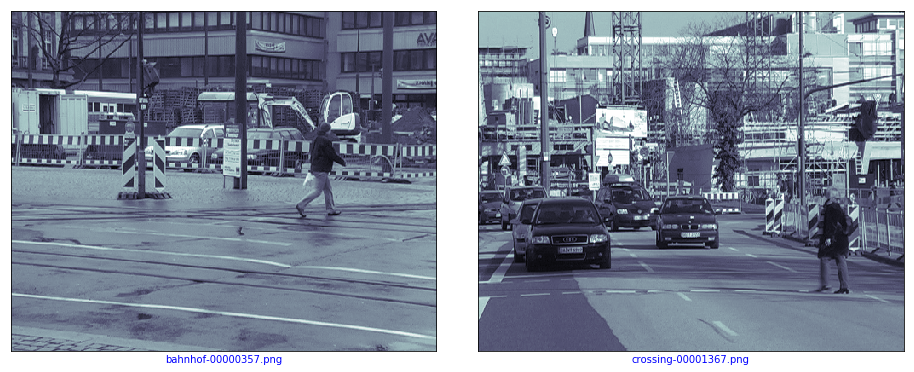

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12), gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='bone')
    ax.set(xticks=[], yticks=[], xlabel=image_files[i][len(path_test_images):])
    ax.xaxis.label.set_color('blue')

### NMS: Non-maxima supression

The models often produce multiple overlapping bounding boxes. **Non-Maxima Suppression** allows the combination of several of these into one bounding box

**References:**
With very minor modifications to suit the code, this function has been entirely taken from the following blog-post
https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
- PyImageSearch is a blog run by Adrian Rosebrock
- Malisiewicz et al. improved the fucntion written earlier by Felzenszwalb et al

In [21]:
## References:
# With very minor modifications to suit the code, this function has been entirely taken from the following blog-post
# https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
# - PyImageSearch is a blog run by Adrian Rosebrock
# - Malisiewicz et al. improved the fucntion written earlier by Felzenszwalb et al

### Non Maxima Supression

def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    # line thickness
    lt = boxes[:,4]
 
    # compute the area of the bounding boxes and sort the bounding    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    # boxes by the bottom-right y-coordinate of the bounding box    
    idxs = np.argsort(y2)
    
    # top-left y coord.
    # idxs = np.argsort(y1)
 
    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the integer data type
    return boxes[pick].astype("int")

### Test: Perspective map method

In [22]:
%%time

# Annotations for final annotated image stored
annotation_1 = 'Presp.Map| {} | prob.:{} | cell:{} bins:{}'.format(MODEL_TYPE, PROBABILITY_THRESHOLD, cell_size, num_bins)
annotation_2 = 'Filter:{} param:{} '.format(apply_filter, filter_param)

if (PERSPECTIVE_MAP):
    
    # Loop through test images
    for n_image in range(len(images)):
        nstr = len(image_files[n_image])-image_files[n_image].rfind('\\')
        annotated_file_name = image_files[n_image][(-nstr+1):]
        print(' - Processing: ', annotated_file_name) 
        
        n_pedestrians = 0
        y_predicted = 0        
        bounding_boxes = [] # Collect all bounding boxes for an image

        # Create a RGB version of gray-scaled image for later annotation
        image_rgb = cv2.cvtColor(images[n_image], cv2.COLOR_GRAY2RGB)

        n_rois = 0
        # Traverse through all horizon levels
        for h in range(len(horizons)):

            # Find where to fix horizon
            y = int(horizons[h] * images[n_image].shape[0])

            # Do multiple passes with decreasing view-port sizes, 
            #   all aligned to the horizon
            for n_pass in range (len(viewports)):
                # Set view-port sizes, start with smallest i.e. farthest pedestrian
                viewport_H = int(training_image_H*viewports[n_pass])
                viewport_W = int(training_image_W*viewports[n_pass])
                step_size = int(viewport_W * STEP_SIZE_FACTOR)
                
                # Traverse horizontally i.e the width of image
                for x in range(0, images[n_image].shape[1], step_size):
                    # Return the current window
                    roi =  images[n_image][y:y+viewport_H, x:x+viewport_W].copy()
                    n_rois += 1
                    
                    # Call custom HoG funtion to get the HoG feature vector
                    X = HoG_V2(roi, apply_filter=apply_filter, filter_param=filter_param)
                    X = X.reshape(1, -1)
                    
                    # Run classifier to see if a pedestrian is detected
                    y_predicted = classifier_model.predict(X)

                    # Check if classifier predicts a pedestrian
                    if (y_predicted == PEDESTRIAN):
                        probability_values = classifier_model.predict_proba(X)
                        pedestrian_probability = probability_values[0][1]
                        
                        # Place a bounding box if: probability > threshold 
                        if (pedestrian_probability >= PROBABILITY_THRESHOLD):
                            n_pedestrians += 1
                            
                            # Bounding-box attributes 
                            line_thickness = n_pass+1                            
                            bounding_boxes.append((x, y, x+viewport_W, y+viewport_H, line_thickness))    
                    # End-if (pedestrian detected)
                # End-for (traverse horizontally for viewport size on one horizon)
            # End-for (traverse horizontally for all view-port sizes on one horizon)
        # End-for (traverse horizontally for all horizons)
        
        # Save annotated image 
        if (n_pedestrians>0):
            bounding_boxes_array = np.asarray(bounding_boxes)
            reduced_bb = non_max_suppression_fast(bounding_boxes_array, 0.3)
            
            print('   _________{} Total BBs. Pedestrians predicted: {}'.format(n_pedestrians, len(reduced_bb)))
            n_pedestrians = len(reduced_bb)

            for bb in reduced_bb:
                (x1, y1, x2, y2, line_thickness) = bb
                
                # Bounding-box attributes
                # (r, g, b) = ((2-n_pass)*80, (1-n_pass)*100, (n_pass)*100)
                # 0: Far, 1: Medium, 2: NEAR
                if (line_thickness == 1): (r, g, b) = (0, 200, 100)
                if (line_thickness == 2): (r, g, b) = (0, 100, 200)
                if (line_thickness == 3): (r, g, b) = (20, 0, 175)
                image_annotated = cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (r, g, b), line_thickness)                                    
                
            # Plot horizon lines
            # [cv2.line(image_rgb, (0, int(h*image_annotated.shape[0])), 
            #          (5, int(h*image_annotated.shape[0])), (180, 120, 0), 1) for h in horizons] 
            
            box_color = (220, 220, 220)
            image_annotated = cv2.rectangle(image_annotated, (10, (images[n_image].shape[0]-60)), 
                    ((images[n_image].shape[1]-10), (images[n_image].shape[0]-10)), box_color,-1)            
            cv2.putText(image_annotated, annotation_1, (20, (images[n_image].shape[0]-40)), cv2.FONT_HERSHEY_PLAIN, 1, (180, 120, 0))                    
            annotation_2 = 'Filter:{} param:{} | Detections: {}'.format(apply_filter, filter_param, n_pedestrians)
            cv2.putText(image_annotated, annotation_2, (20, (images[n_image].shape[0]-20)), cv2.FONT_HERSHEY_PLAIN, 1, (180, 120, 0))

            # Save the annotated image
            title = MODEL_TYPE + '_pMap_' + annotated_file_name 
            cv2.imwrite(annotated_images_path + title, image_annotated)
            
        # End processing of one test image
            
    # Loop through all test images
# End-if perspective map method
                       
cv2.destroyAllWindows()

print('\n Perspective map method done')

 - Processing:  bahnhof-00000357.png
   _________3 Total BBs. Pedestrians predicted: 2
 - Processing:  crossing-00001367.png
   _________21 Total BBs. Pedestrians predicted: 8
 - Processing:  crossing-00001408.png
   _________24 Total BBs. Pedestrians predicted: 7
 - Processing:  crossing-00002598.png
   _________2 Total BBs. Pedestrians predicted: 1
 - Processing:  luisenplatz-00001970.png
   _________5 Total BBs. Pedestrians predicted: 3
 - Processing:  schloss-rain-00000318.png
 - Processing:  schloss-rain-00000980.png
   _________3 Total BBs. Pedestrians predicted: 1
 - Processing:  schloss-rain-00000996.png
   _________1 Total BBs. Pedestrians predicted: 1
 - Processing:  schloss-rain-00001372.png
 - Processing:  schloss-rain-00001417.png
 - Processing:  schloss-rain-00001443.png
 - Processing:  schloss-rain-00001662.png
   _________3 Total BBs. Pedestrians predicted: 1
 - Processing:  schloss-rain-00001673.png
 - Processing:  schloss-rain-00001813.png
   _________1 Total BBs. Ped

## Annotated images

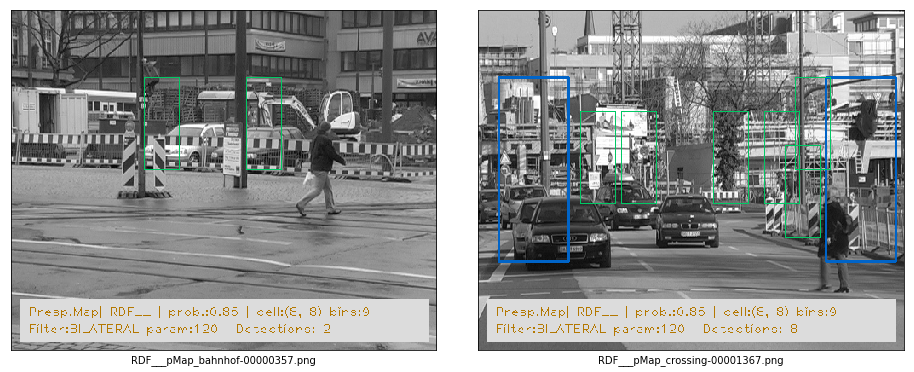

In [23]:
# Load images
image_annotated_files = []
images_annotated = []

# Gather all test .png file names
image_annotated_files = glob.glob (annotated_images_path + file_type)

# Move through all .png files in folder and append to a local array of images
images_annotated = np.array([np.array(cv2.imread(image_file, cv2.IMREAD_COLOR)) 
                                for image_file in image_annotated_files])

fig, axes = plt.subplots(1, 2, figsize=(16, 12), gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):    
    ax.imshow(images_annotated[i])
    ax.set(xticks=[], yticks=[], xlabel=image_annotated_files[i][len(annotated_images_path):])

### Test: Simple scan method

Use simple scanning from top to bottom, left to right with a fized view-port sized window

This method does not use perspective-map technique

In [24]:
%%time

# Un-comment to force test simple scanning
PERSPECTIVE_MAP = False

# Annotations for final annotated image stored
annotation_1 = 'Full-scan| {} | prob.:{} | cell:{} bins:{}'.format(MODEL_TYPE, PROBABILITY_THRESHOLD, cell_size, num_bins)

if (not PERSPECTIVE_MAP):
    
    viewport_H = int(training_image_H)
    viewport_W = int(training_image_W)
    step_size = int(viewport_W * STEP_SIZE_FACTOR)

    for n_image in range(len(images)):
        n_rois = 0
        n_pedestrians = 0
        y_predicted=0
        bounding_boxes = [] # Collect all bounding boxes for an image

        nstr = len(image_files[n_image])-image_files[n_image].rfind('\\')
        annotated_file_name = image_files[n_image][(-nstr+1):]
        print(' - Processing: ', annotated_file_name) 
        
        # Create a RGB version of gray-scaled image for later annotation
        image_rgb = cv2.cvtColor(images[n_image], cv2.COLOR_GRAY2RGB)

        # Traverse vertically i.e the height of image
        # Stop at 50% of Viewport Height, do not scan below that
        for y in range(0, images[n_image].shape[0]-int(0.5*viewport_H), step_size):

            # Traverse horizontally i.e the width of image
            for x in range(0, images[n_image].shape[1], step_size):

                # Return the current window
                roi =  images[n_image][y:y+viewport_H, x:x+viewport_W].copy()
                n_rois += 1
                
                # Call custom HoG funtion to get the HoG feature vector
                X = HoG_V2(roi, apply_filter = apply_filter, filter_param = filter_param)
                X = X.reshape(1, -1)
                    
                y_predicted = classifier_model.predict(X)
                if (y_predicted == PEDESTRIAN):
                    probability_values = classifier_model.predict_proba(X)
                    pedestrian_probability = probability_values[0][1]
                    
                    # Place a bounding box if: probability > threshold 
                    if (pedestrian_probability >= PROBABILITY_THRESHOLD):    
                        n_pedestrians += 1
                        # Bounding-box attributes                          
                        bounding_boxes.append((x, y, x+viewport_W, y+viewport_H, 2))
        # Save annotated image 
        if (n_pedestrians>0):
            bounding_boxes = np.asarray(bounding_boxes)
            reduced_bb = non_max_suppression_fast(bounding_boxes, 0.3)
            print('   _________{} Total BBs. Pedestrians predicted: {}'.format(n_pedestrians, len(reduced_bb)))
            n_pedestrians=len(reduced_bb)
 
            for bb in reduced_bb:
                (x1, y1, x2, y2, line_thickness) = bb                                                                            
                image_annotated = cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 160, 120), 2)    
                
            box_color = (220, 220, 220)
            image_annotated = cv2.rectangle(image_annotated, (10, (images[n_image].shape[0]-60)), 
                    ((images[n_image].shape[1]-10), (images[n_image].shape[0]-10)), box_color,-1)            
            cv2.putText(image_annotated, annotation_1, (20, (images[n_image].shape[0]-40)), cv2.FONT_HERSHEY_PLAIN, 1, (180, 120, 0))                    
            annotation_2 = 'Filter:{} param:{} | Detections: {}'.format(apply_filter, filter_param, n_pedestrians)
            cv2.putText(image_annotated, annotation_2, (20, (images[n_image].shape[0]-20)), cv2.FONT_HERSHEY_PLAIN, 1, (180, 120, 0))

            # Save the annotated image
            title = MODEL_TYPE + annotated_file_name 
            cv2.imwrite(annotated_images_path + title, image_annotated)
            
    # Loop through all test images
# End-if non-perspective map method
                       
cv2.destroyAllWindows()

print('\n Normal testing done')

 - Processing:  bahnhof-00000357.png
   _________2 Total BBs. Pedestrians predicted: 1
 - Processing:  crossing-00001367.png
   _________12 Total BBs. Pedestrians predicted: 4
 - Processing:  crossing-00001408.png
   _________9 Total BBs. Pedestrians predicted: 5
 - Processing:  crossing-00002598.png
   _________7 Total BBs. Pedestrians predicted: 2
 - Processing:  luisenplatz-00001970.png
   _________7 Total BBs. Pedestrians predicted: 4
 - Processing:  schloss-rain-00000318.png
 - Processing:  schloss-rain-00000980.png
 - Processing:  schloss-rain-00000996.png
   _________2 Total BBs. Pedestrians predicted: 2
 - Processing:  schloss-rain-00001372.png
   _________1 Total BBs. Pedestrians predicted: 1
 - Processing:  schloss-rain-00001417.png
   _________1 Total BBs. Pedestrians predicted: 1
 - Processing:  schloss-rain-00001443.png
 - Processing:  schloss-rain-00001662.png
   _________5 Total BBs. Pedestrians predicted: 1
 - Processing:  schloss-rain-00001673.png
 - Processing:  schlo